# Feasibility study 

Here we are gonna explore if it is feasible to run Bayesian optimization in the context of oprimizing 3D-printing of cdECM-NP material.

We are going to assume that we have 3 input parameters: 
- speed, 
- pressure, 
- needle gauge.

And we are optimizing for 1 output parameter:
- material accuracy.

We also assume that we have previously conducted the full-factorial study with **8 initial datapoints** - we use this to initialize the bayesian optimizer.

We assume we are going to run the experiment until convergence (best case scenario).

We will monitor how much time the iterations take (in case we have to hard-code the number of iterations needed). 



In [33]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import gpflow
import trieste

from time import time, sleep
import random

from trieste.ask_tell_optimization import AskTellOptimizer
from trieste.bayesian_optimizer import Record
from trieste.data import Dataset
from trieste.models.gpflow.models import GaussianProcessRegression
from trieste.objectives.utils import mk_observer
from trieste.observer import OBJECTIVE
from trieste.space import Box
from util.plotting import plot_function_2d, plot_bo_points

np.random.seed(1234)
tf.random.set_seed(1234)

### Important parameters of the algorithm:

**Gaussian Process parameters:**

1. **Kernel function** (below the choice is given as a Matern52, but it could be many other kernels). In the presentation linked in the theoretical part they show how the nature of functions described with the gaussian process is dfined by a kernel. So this is really a key parameter, as seen [here](https://gpflow.readthedocs.io/en/v1.5.1-docs/notebooks/advanced/kernels.html):


<img src="Kernels.PNG" width="400"/>

2. **Kernel hyperparameters** the kernels themselves also have certain parameters that can be changes and will inflience the "look" of the functions. 

3. **Additional things to think about when formulating the Gaussian Process** with a diagram given here: https://nbviewer.org/github/GPflow/GPflow/blob/develop-1.0/doc/source/notebooks/GPflows.png

**Acquisition function parameters:**

Different acquisition functions have different trade-offs between exploration and exploitation (going to the maximum of the function VS exploring unvisited spaces). They also have their own hyper parameters that could be tweeked.

DiscreteThompsonSampling is one acquisition rule that is picked here. Others options could be EfficientGlobalOptimization with any of the standard acquisition functions such as expected improvement etc. 

The acquisition function will influence how the new evidence points are suggested.

In [2]:
def build_model(data, kernel_func=None):
    """kernel_func should be a function that takes variance as a single input parameter"""
    variance = tf.math.reduce_variance(data.observations)
    if kernel_func is None:
        kernel = gpflow.kernels.Matern52(variance=variance)
    else:
        kernel = kernel_func(variance)
    gpr = gpflow.models.GPR(data.astuple(), kernel, noise_variance=1e-5)
    # I am not sure why we set the gpr.likelihood to false here :/ 
    gpflow.set_trainable(gpr.likelihood, False)

    return GaussianProcessRegression(gpr)

def plot_ask_tell_results(ask_tell_result):
    dataset = ask_tell_result.try_get_final_dataset()
    query_points = dataset.query_points.numpy()
    observations = dataset.observations.numpy()
    fig, ax = plt.subplots()

    sc = ax.scatter(query_points[:, 0], query_points[:,1], c=observations)
    ax.set_ylabel('Pressure', loc='top')
    ax.set_xlabel('Speed', loc='left')
    cbar = fig.colorbar(sc)
    cbar.set_label("Material Accuracy", loc='top')

    plt.show()

## Our search-space has at least 3 dimensions

In [50]:
# define our 3D search space
# let's say speed can range from 1-12
# pressure can range from 1-6
# needle gaufe can range from 1-4
search_space = Box([1, 1, 1], [12, 6, 4])

# we have 8 initial points that cover the lowest and the highest possible printing values
num_initial_points = 8

initial_x = np.array([[1,1,1], 
                 [1,1,4], 
                 [1,4,1], 
                 [1,4,4], 
                 [12,1,1], 
                 [12,1,4], 
                 [12,4,1], 
                 [12,4,4]
            ])

initial_y = np.array([[0.384], [0.462], [0.768], [0.332], [0.738], [0.462], [0.207], [0.127]])

initial_data = trieste.data.Dataset(
    tf.constant(initial_x, dtype ='float64'), 
    tf.constant(initial_y, dtype ='float64'))


In [51]:
# we initialize the Thompson Sampling which will tell us which point to choose next
acq_rule = trieste.acquisition.rule.DiscreteThompsonSampling(
    num_search_space_samples=1000, num_query_points=1
)

In [58]:
%time

# we initialize the gaussian process with this data
model = build_model(initial_data)
# we formulate the ask-tell optimizer
ask_tell = AskTellOptimizer(search_space, initial_data, model, acq_rule)

Wall time: 0 ns


Wall time: 0 ns
Iteration #0
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 1
Speed (mm/s):  4.1
Pressure (bars):  6.0 

Needle (mm):  3.8 



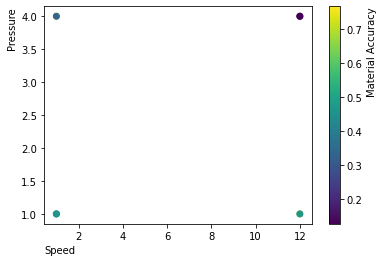

Printed material accuracy of 0.49836078328544686
Iteration #1
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 2
Speed (mm/s):  11.5
Pressure (bars):  5.9 

Needle (mm):  3.4 



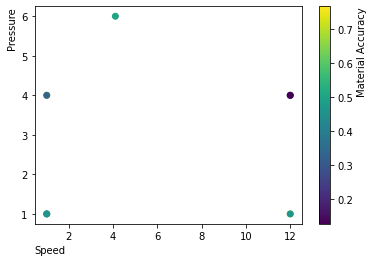

Printed material accuracy of 0.8533070993265619
Iteration #2
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 3
Speed (mm/s):  5.1
Pressure (bars):  1.5 

Needle (mm):  4.0 



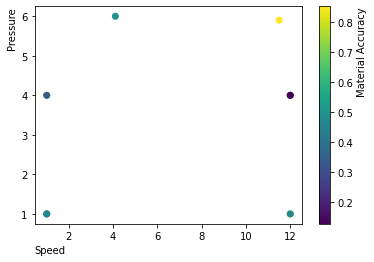

Printed material accuracy of 0.769537759853778
Iteration #3
Ask Trieste for configuration
Trieste took 0.12s to answer
New Configuration to Try # 4
Speed (mm/s):  1.0
Pressure (bars):  6.0 

Needle (mm):  4.0 



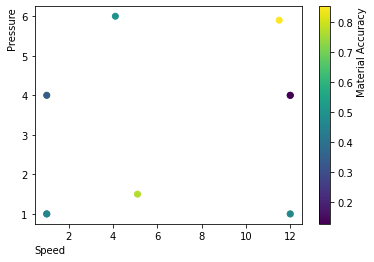

Printed material accuracy of 0.9651744330992955
Iteration #4
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 5
Speed (mm/s):  4.1
Pressure (bars):  3.7 

Needle (mm):  1.8 



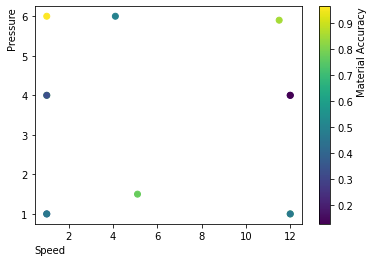

Printed material accuracy of 0.25251032462812373
Iteration #5
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 6
Speed (mm/s):  7.1
Pressure (bars):  6.0 

Needle (mm):  3.5 



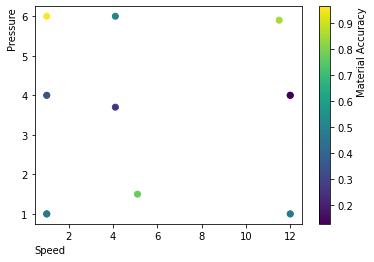

Printed material accuracy of 0.006629729804032758
Iteration #6
Ask Trieste for configuration
Trieste took 0.12s to answer
New Configuration to Try # 7
Speed (mm/s):  7.7
Pressure (bars):  5.3 

Needle (mm):  1.7 



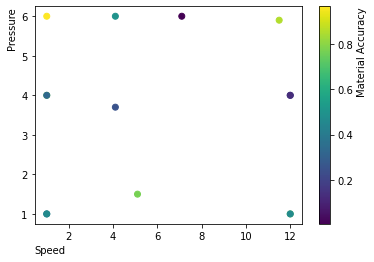

Printed material accuracy of 0.310054438003439
Iteration #7
Ask Trieste for configuration
Trieste took 0.12s to answer
New Configuration to Try # 8
Speed (mm/s):  8.8
Pressure (bars):  2.7 

Needle (mm):  1.2 



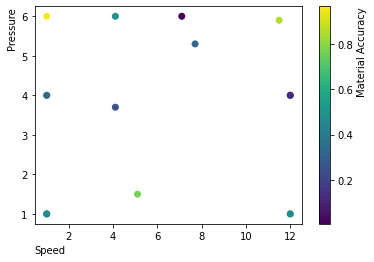

Printed material accuracy of 0.036330920896096464
Iteration #8
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 9
Speed (mm/s):  10.6
Pressure (bars):  4.2 

Needle (mm):  1.8 



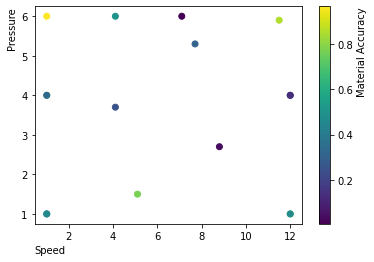

Printed material accuracy of 0.6487752891297551
Iteration #9
Ask Trieste for configuration
Trieste took 0.12s to answer
New Configuration to Try # 10
Speed (mm/s):  9.7
Pressure (bars):  2.8 

Needle (mm):  4.0 



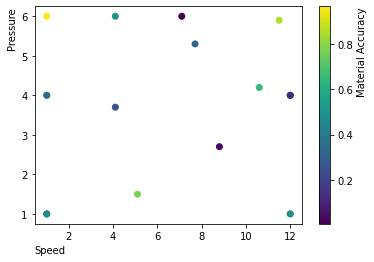

Printed material accuracy of 0.9890119837901328
Iteration #10
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 11
Speed (mm/s):  4.6
Pressure (bars):  1.9 

Needle (mm):  1.5 



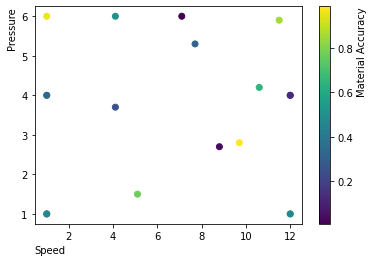

Printed material accuracy of 0.21982449691930683
Iteration #11
Ask Trieste for configuration
Trieste took 0.12s to answer
New Configuration to Try # 12
Speed (mm/s):  11.9
Pressure (bars):  3.2 

Needle (mm):  3.4 



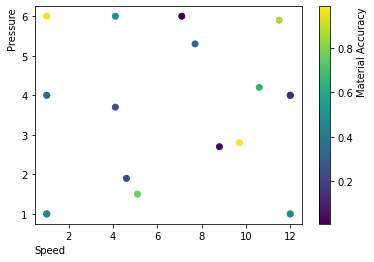

Printed material accuracy of 0.7946316594351425
Iteration #12
Ask Trieste for configuration
Trieste took 0.12s to answer
New Configuration to Try # 13
Speed (mm/s):  5.7
Pressure (bars):  5.1 

Needle (mm):  2.1 



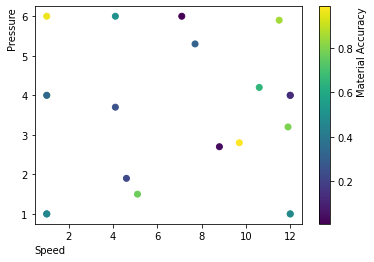

Printed material accuracy of 0.938662130376153
Iteration #13
Ask Trieste for configuration
Trieste took 0.12s to answer
New Configuration to Try # 14
Speed (mm/s):  6.3
Pressure (bars):  2.7 

Needle (mm):  1.8 



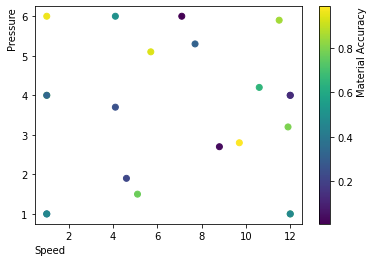

Printed material accuracy of 0.24295145662376072
Iteration #14
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 15
Speed (mm/s):  11.2
Pressure (bars):  5.2 

Needle (mm):  1.4 



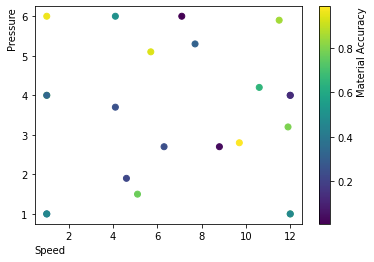

Printed material accuracy of 0.20546380737969538
Iteration #15
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 16
Speed (mm/s):  8.0
Pressure (bars):  4.8 

Needle (mm):  3.5 



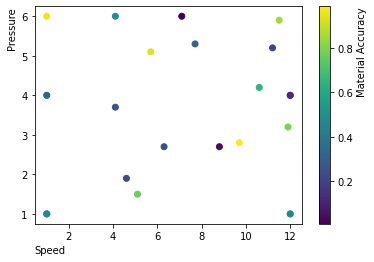

Printed material accuracy of 0.9024293515394524
Iteration #16
Ask Trieste for configuration
Trieste took 0.12s to answer
New Configuration to Try # 17
Speed (mm/s):  3.1
Pressure (bars):  5.9 

Needle (mm):  1.4 



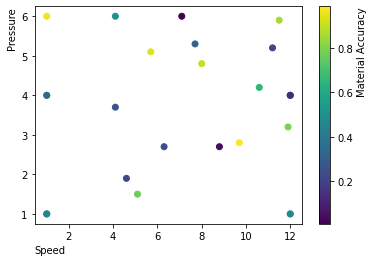

Printed material accuracy of 0.5942019593702118
Iteration #17
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 18
Speed (mm/s):  2.8
Pressure (bars):  3.8 

Needle (mm):  3.8 



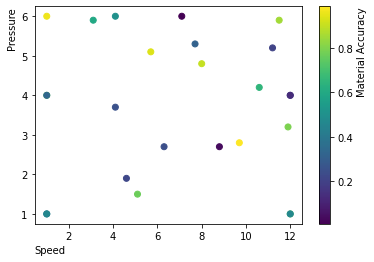

Printed material accuracy of 0.7414071235965102
Iteration #18
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 19
Speed (mm/s):  6.6
Pressure (bars):  5.9 

Needle (mm):  1.1 



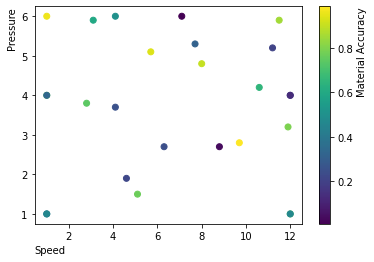

Printed material accuracy of 0.4461032462144431
Iteration #19
Ask Trieste for configuration
Trieste took 0.12s to answer
New Configuration to Try # 20
Speed (mm/s):  8.6
Pressure (bars):  1.0 

Needle (mm):  2.7 



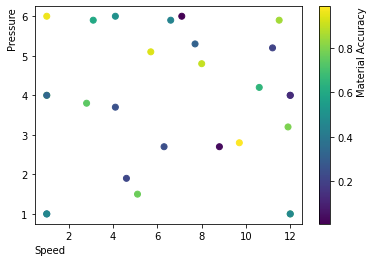

Printed material accuracy of 0.9697183701608114
Iteration #20
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 21
Speed (mm/s):  7.8
Pressure (bars):  3.2 

Needle (mm):  3.4 



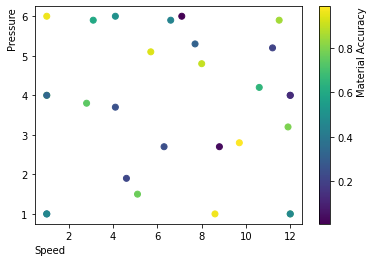

Printed material accuracy of 0.8295537302182519
Iteration #21
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 22
Speed (mm/s):  3.2
Pressure (bars):  4.1 

Needle (mm):  1.5 



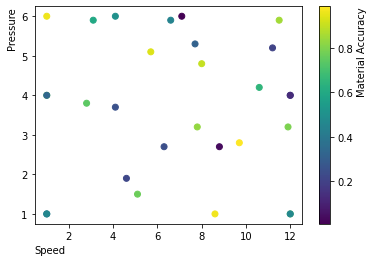

Printed material accuracy of 0.8507969115231757
Iteration #22
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 23
Speed (mm/s):  11.9
Pressure (bars):  5.7 

Needle (mm):  1.0 



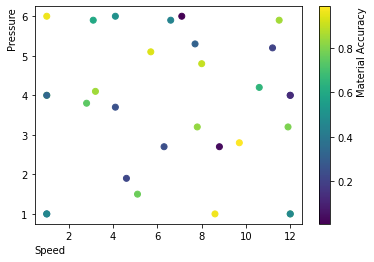

Printed material accuracy of 0.8776316119775494
Iteration #23
Ask Trieste for configuration
Trieste took 0.12s to answer
New Configuration to Try # 24
Speed (mm/s):  7.8
Pressure (bars):  3.1 

Needle (mm):  1.0 



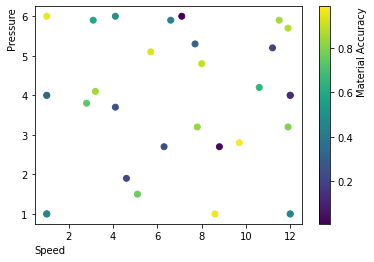

Printed material accuracy of 0.3451432475694479
Iteration #24
Ask Trieste for configuration
Trieste took 0.12s to answer
New Configuration to Try # 25
Speed (mm/s):  6.7
Pressure (bars):  1.4 

Needle (mm):  1.3 



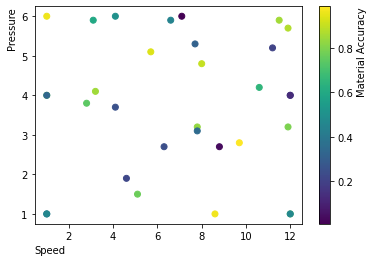

Printed material accuracy of 0.4093162608013011
Iteration #25
Ask Trieste for configuration
Trieste took 0.12s to answer
New Configuration to Try # 26
Speed (mm/s):  5.7
Pressure (bars):  5.9 

Needle (mm):  3.9 



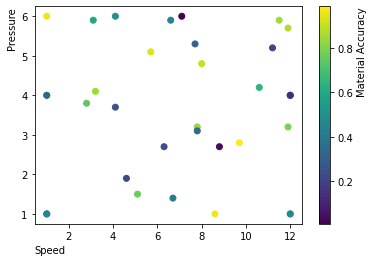

Printed material accuracy of 0.5743304443902737
Iteration #26
Ask Trieste for configuration
Trieste took 0.17s to answer
New Configuration to Try # 27
Speed (mm/s):  3.1
Pressure (bars):  1.3 

Needle (mm):  2.2 



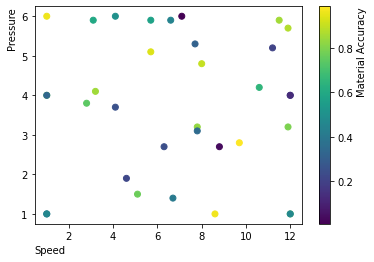

Printed material accuracy of 0.526644146601821
Iteration #27
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 28
Speed (mm/s):  3.9
Pressure (bars):  1.8 

Needle (mm):  2.7 



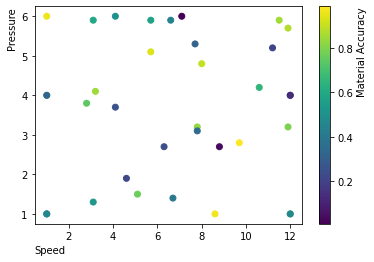

Printed material accuracy of 0.9838400935524865
Iteration #28
Ask Trieste for configuration
Trieste took 0.15s to answer
New Configuration to Try # 29
Speed (mm/s):  9.7
Pressure (bars):  1.4 

Needle (mm):  1.4 



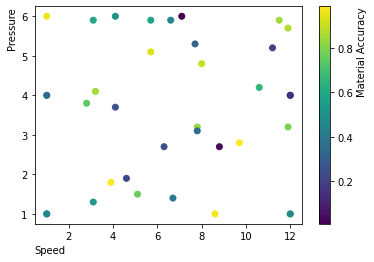

Printed material accuracy of 0.2665878504252459
Iteration #29
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 30
Speed (mm/s):  9.6
Pressure (bars):  5.9 

Needle (mm):  1.1 



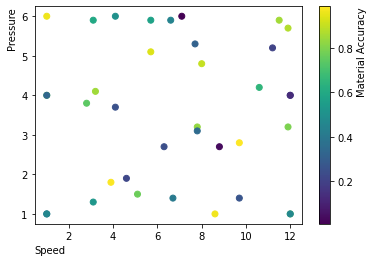

Printed material accuracy of 0.35945934573945904
Iteration #30
Ask Trieste for configuration
Trieste took 0.12s to answer
New Configuration to Try # 31
Speed (mm/s):  9.7
Pressure (bars):  4.1 

Needle (mm):  1.1 



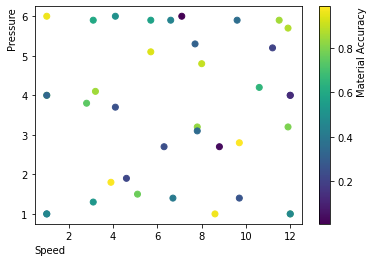

Printed material accuracy of 0.730611888469041
Iteration #31
Ask Trieste for configuration
Trieste took 0.12s to answer
New Configuration to Try # 32
Speed (mm/s):  4.8
Pressure (bars):  3.2 

Needle (mm):  1.3 



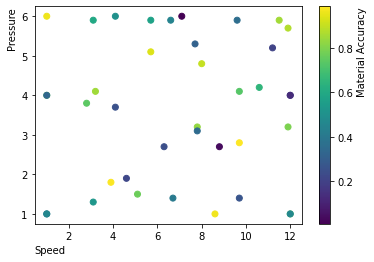

Printed material accuracy of 0.5369382316871715
Iteration #32
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 33
Speed (mm/s):  7.2
Pressure (bars):  5.9 

Needle (mm):  2.4 



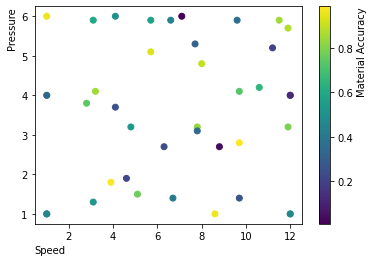

Printed material accuracy of 0.34407200633890445
Iteration #33
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 34
Speed (mm/s):  10.6
Pressure (bars):  4.6 

Needle (mm):  3.9 



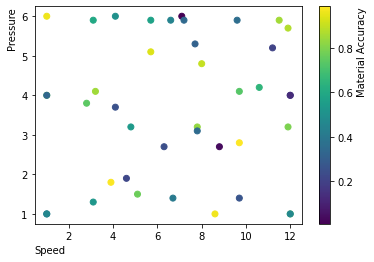

Printed material accuracy of 0.517341226243701
Iteration #34
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 35
Speed (mm/s):  3.6
Pressure (bars):  1.2 

Needle (mm):  1.3 



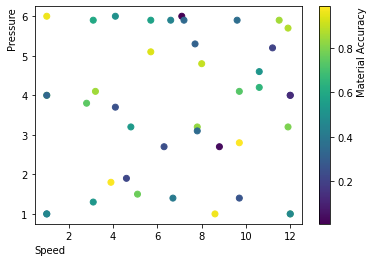

Printed material accuracy of 0.7530637387383253
Iteration #35
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 36
Speed (mm/s):  8.5
Pressure (bars):  5.6 

Needle (mm):  3.9 



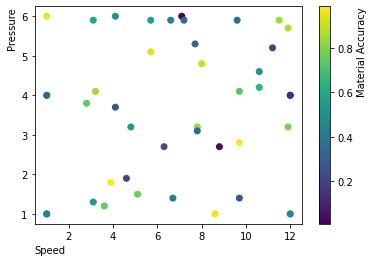

Printed material accuracy of 0.7695333084636671
Iteration #36
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 37
Speed (mm/s):  1.9
Pressure (bars):  3.2 

Needle (mm):  2.4 



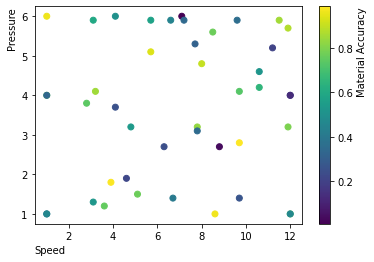

Printed material accuracy of 0.8806492169065587
Iteration #37
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 38
Speed (mm/s):  5.8
Pressure (bars):  3.3 

Needle (mm):  3.0 



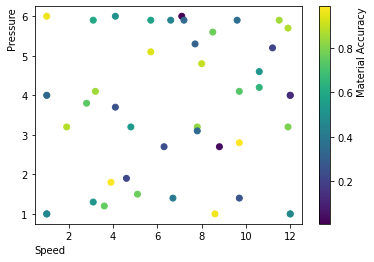

Printed material accuracy of 0.8766704960894323
Iteration #38
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 39
Speed (mm/s):  1.6
Pressure (bars):  6.0 

Needle (mm):  1.2 



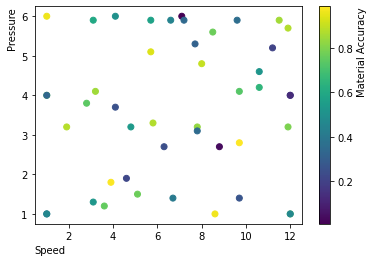

Printed material accuracy of 0.40413318434643586
Iteration #39
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 40
Speed (mm/s):  11.0
Pressure (bars):  1.2 

Needle (mm):  1.0 



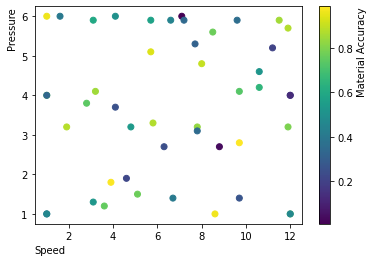

Printed material accuracy of 0.011820809203208271
Iteration #40
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 41
Speed (mm/s):  10.2
Pressure (bars):  2.3 

Needle (mm):  2.0 



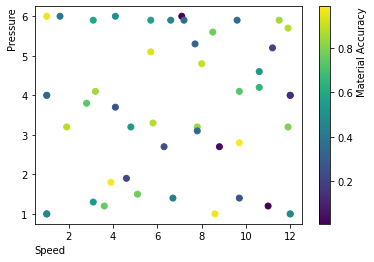

Printed material accuracy of 0.8335783663906421
Iteration #41
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 42
Speed (mm/s):  4.7
Pressure (bars):  4.4 

Needle (mm):  1.4 



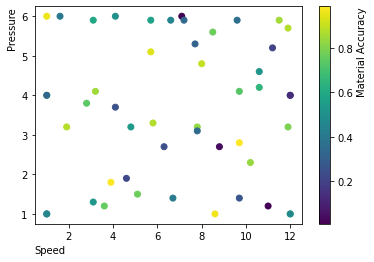

Printed material accuracy of 0.7154993919842176
Iteration #42
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 43
Speed (mm/s):  5.7
Pressure (bars):  2.2 

Needle (mm):  1.4 



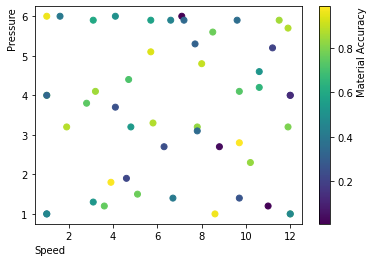

Printed material accuracy of 0.26259187836441134
Iteration #43
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 44
Speed (mm/s):  9.3
Pressure (bars):  2.3 

Needle (mm):  1.1 



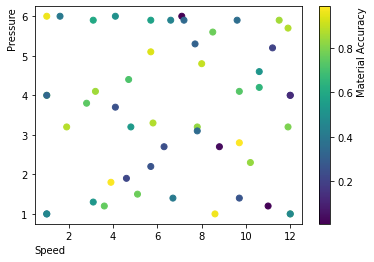

Printed material accuracy of 0.13733000725365863
Iteration #44
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 45
Speed (mm/s):  4.2
Pressure (bars):  4.9 

Needle (mm):  3.5 



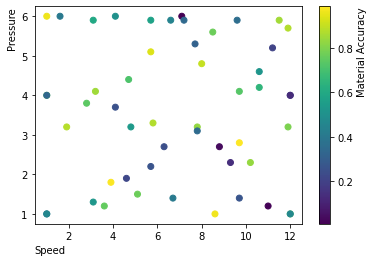

Printed material accuracy of 0.9923610378156194
Iteration #45
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 46
Speed (mm/s):  11.6
Pressure (bars):  4.5 

Needle (mm):  3.5 



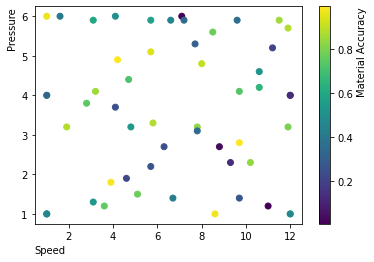

Printed material accuracy of 0.2774342382793973
Iteration #46
Ask Trieste for configuration
Trieste took 0.12s to answer
New Configuration to Try # 47
Speed (mm/s):  8.1
Pressure (bars):  3.1 

Needle (mm):  2.1 



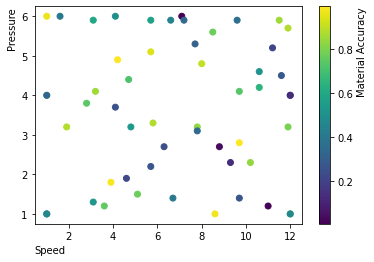

Printed material accuracy of 0.07133159544467926
Iteration #47
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 48
Speed (mm/s):  8.0
Pressure (bars):  6.0 

Needle (mm):  2.6 



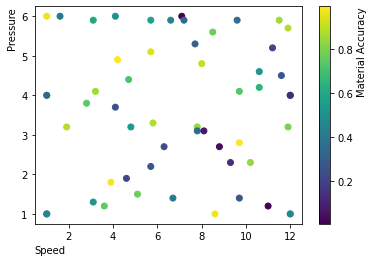

Printed material accuracy of 0.4271168061016902
Iteration #48
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 49
Speed (mm/s):  4.1
Pressure (bars):  2.7 

Needle (mm):  1.6 



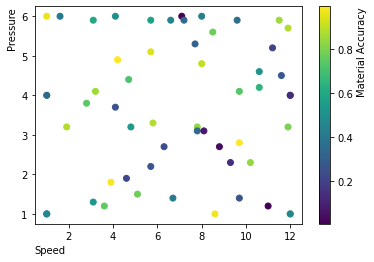

Printed material accuracy of 0.6458125759388403
Iteration #49
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 50
Speed (mm/s):  7.1
Pressure (bars):  1.0 

Needle (mm):  3.9 



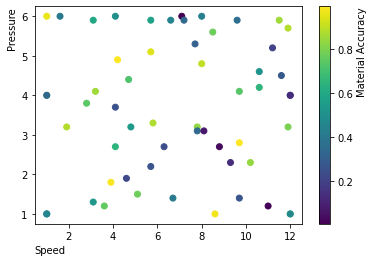

Printed material accuracy of 0.9749271797285053
Iteration #50
Ask Trieste for configuration
Trieste took 0.12s to answer
New Configuration to Try # 51
Speed (mm/s):  8.2
Pressure (bars):  2.3 

Needle (mm):  1.3 



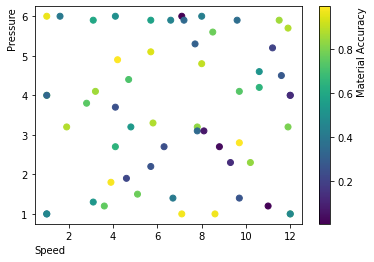

Printed material accuracy of 0.8046368890231532
Iteration #51
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 52
Speed (mm/s):  5.4
Pressure (bars):  1.1 

Needle (mm):  1.1 



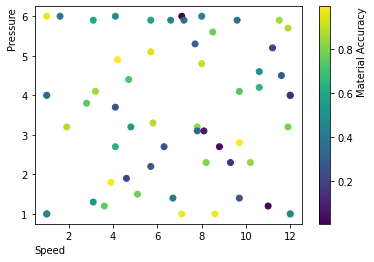

Printed material accuracy of 0.39329160538812336
Iteration #52
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 53
Speed (mm/s):  2.6
Pressure (bars):  5.8 

Needle (mm):  2.6 



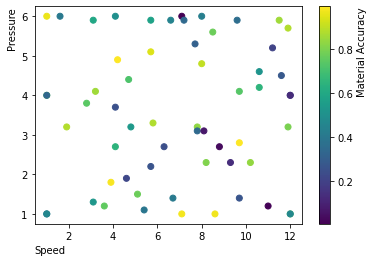

Printed material accuracy of 0.49000703315236305
Iteration #53
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 54
Speed (mm/s):  10.2
Pressure (bars):  5.9 

Needle (mm):  3.2 



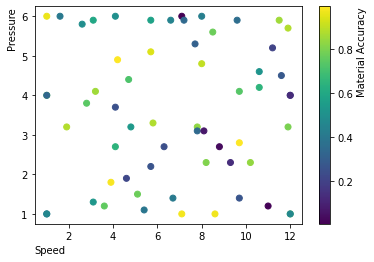

Printed material accuracy of 0.07009327407751187
Iteration #54
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 55
Speed (mm/s):  7.6
Pressure (bars):  5.6 

Needle (mm):  1.1 



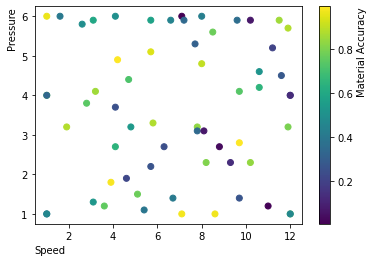

Printed material accuracy of 0.49216140032875644
Iteration #55
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 56
Speed (mm/s):  1.8
Pressure (bars):  1.0 

Needle (mm):  2.8 



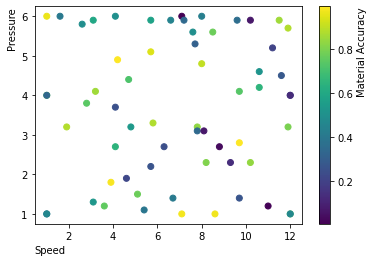

Printed material accuracy of 0.20940248465582
Iteration #56
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 57
Speed (mm/s):  11.0
Pressure (bars):  5.3 

Needle (mm):  2.5 



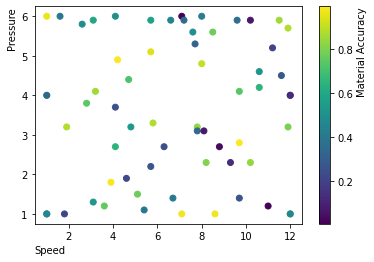

Printed material accuracy of 0.19607806806637296
Iteration #57
Ask Trieste for configuration
Trieste took 0.15s to answer
New Configuration to Try # 58
Speed (mm/s):  6.4
Pressure (bars):  3.1 

Needle (mm):  1.1 



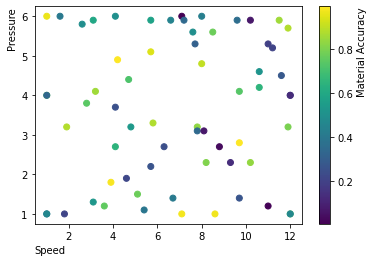

Printed material accuracy of 0.32209872440344955
Iteration #58
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 59
Speed (mm/s):  9.8
Pressure (bars):  5.8 

Needle (mm):  1.9 



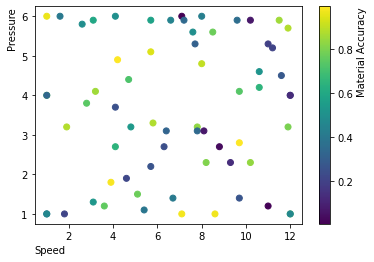

Printed material accuracy of 0.9249704416549792
Iteration #59
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 60
Speed (mm/s):  10.2
Pressure (bars):  1.0 

Needle (mm):  1.4 



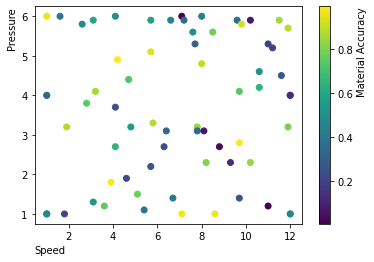

Printed material accuracy of 0.48449534835267494
Iteration #60
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 61
Speed (mm/s):  1.0
Pressure (bars):  2.3 

Needle (mm):  2.8 



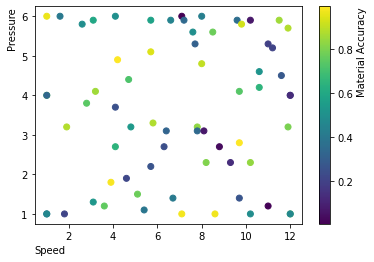

Printed material accuracy of 0.7309659510172642
Iteration #61
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 62
Speed (mm/s):  9.0
Pressure (bars):  3.2 

Needle (mm):  1.3 



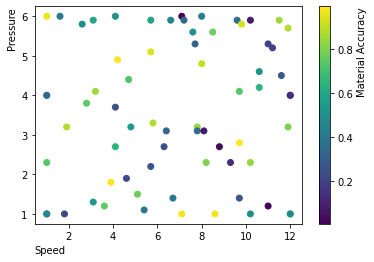

Printed material accuracy of 0.34546144534564927
Iteration #62
Ask Trieste for configuration
Trieste took 0.15s to answer
New Configuration to Try # 63
Speed (mm/s):  7.9
Pressure (bars):  3.9 

Needle (mm):  2.1 



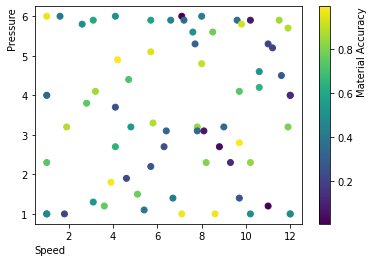

Printed material accuracy of 0.7875101948608899
Iteration #63
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 64
Speed (mm/s):  3.3
Pressure (bars):  1.7 

Needle (mm):  3.9 



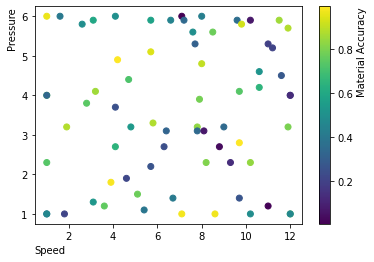

Printed material accuracy of 0.5700806016223322
Iteration #64
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 65
Speed (mm/s):  1.2
Pressure (bars):  4.9 

Needle (mm):  1.6 



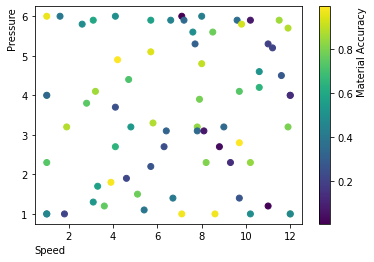

Printed material accuracy of 0.11536843851915879
Iteration #65
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 66
Speed (mm/s):  6.7
Pressure (bars):  3.7 

Needle (mm):  1.5 



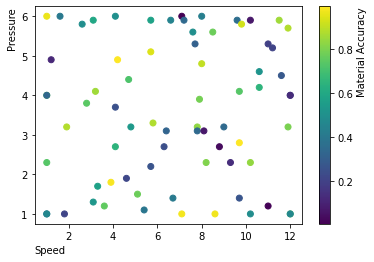

Printed material accuracy of 0.6120049189175455
Iteration #66
Ask Trieste for configuration
Trieste took 0.15s to answer
New Configuration to Try # 67
Speed (mm/s):  2.2
Pressure (bars):  1.7 

Needle (mm):  1.7 



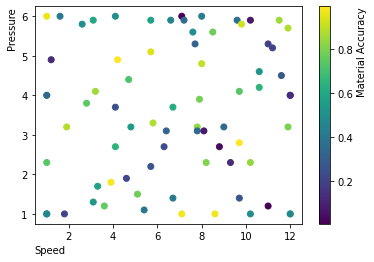

Printed material accuracy of 0.8745516708860667
Iteration #67
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 68
Speed (mm/s):  3.2
Pressure (bars):  5.6 

Needle (mm):  3.8 



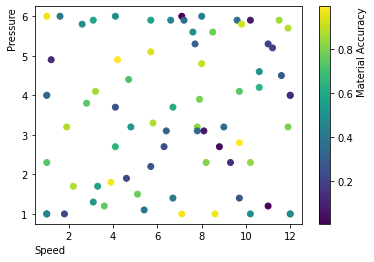

Printed material accuracy of 0.07229499843184473
Iteration #68
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 69
Speed (mm/s):  3.7
Pressure (bars):  4.8 

Needle (mm):  2.3 



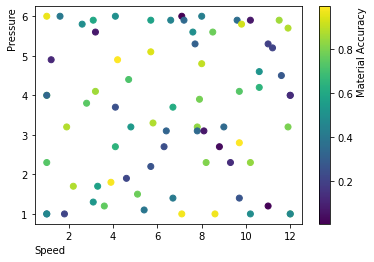

Printed material accuracy of 0.34559120376503316
Iteration #69
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 70
Speed (mm/s):  10.2
Pressure (bars):  1.4 

Needle (mm):  3.9 



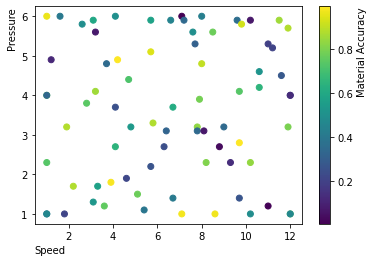

Printed material accuracy of 0.8874698613898568
Iteration #70
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 71
Speed (mm/s):  8.5
Pressure (bars):  2.8 

Needle (mm):  3.1 



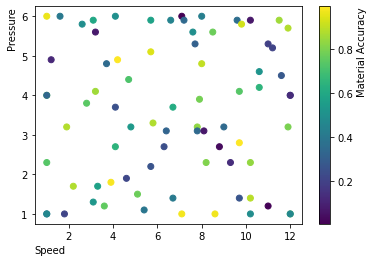

Printed material accuracy of 0.6663792909516337
Iteration #71
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 72
Speed (mm/s):  11.8
Pressure (bars):  2.2 

Needle (mm):  2.3 



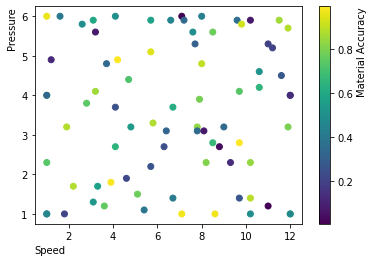

Printed material accuracy of 0.01581524408622914
Iteration #72
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 73
Speed (mm/s):  12.0
Pressure (bars):  2.7 

Needle (mm):  1.4 



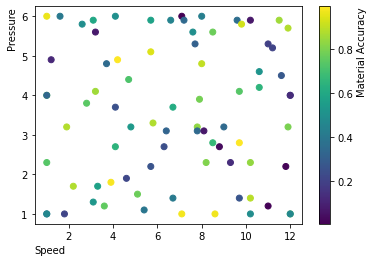

Printed material accuracy of 0.24568122662924397
Iteration #73
Ask Trieste for configuration
Trieste took 0.12s to answer
New Configuration to Try # 74
Speed (mm/s):  8.8
Pressure (bars):  2.3 

Needle (mm):  2.4 



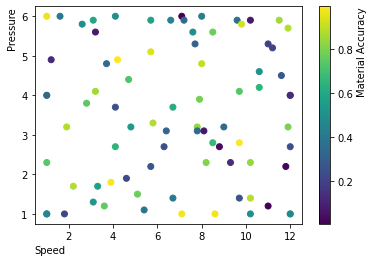

Printed material accuracy of 0.18764984878768787
Iteration #74
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 75
Speed (mm/s):  11.9
Pressure (bars):  3.3 

Needle (mm):  2.4 



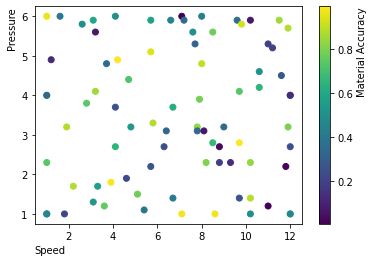

Printed material accuracy of 0.5606462427453343
Iteration #75
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 76
Speed (mm/s):  10.8
Pressure (bars):  5.7 

Needle (mm):  1.8 



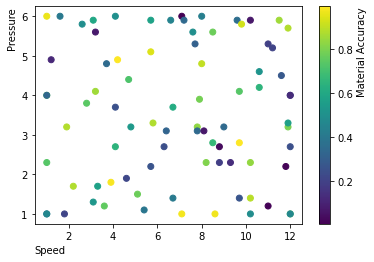

Printed material accuracy of 0.7011560133444553
Iteration #76
Ask Trieste for configuration
Trieste took 0.15s to answer
New Configuration to Try # 77
Speed (mm/s):  1.2
Pressure (bars):  2.7 

Needle (mm):  3.6 



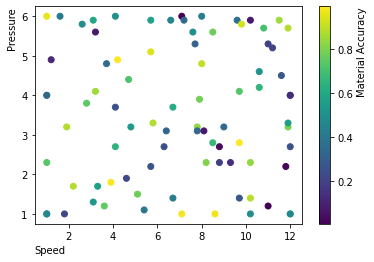

Printed material accuracy of 0.07871662757406417
Iteration #77
Ask Trieste for configuration
Trieste took 0.15s to answer
New Configuration to Try # 78
Speed (mm/s):  1.9
Pressure (bars):  5.2 

Needle (mm):  3.0 



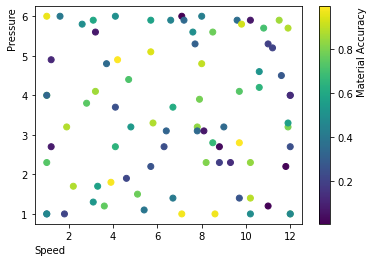

Printed material accuracy of 0.8663301500690485
Iteration #78
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 79
Speed (mm/s):  1.9
Pressure (bars):  2.3 

Needle (mm):  4.0 



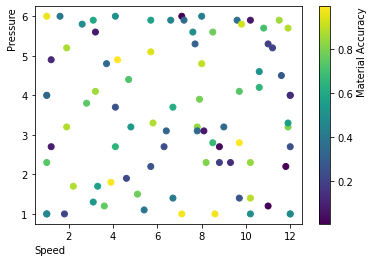

Printed material accuracy of 0.18384391424213475
Iteration #79
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 80
Speed (mm/s):  4.7
Pressure (bars):  6.0 

Needle (mm):  2.5 



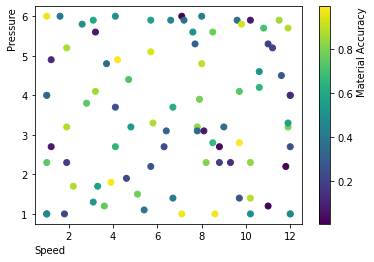

Printed material accuracy of 0.9878944306318914
Iteration #80
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 81
Speed (mm/s):  3.6
Pressure (bars):  2.9 

Needle (mm):  3.9 



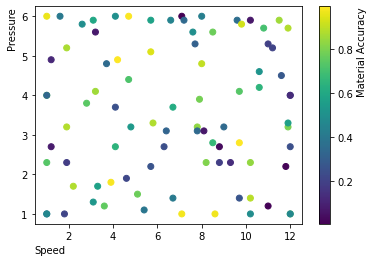

Printed material accuracy of 0.8251194718061096
Iteration #81
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 82
Speed (mm/s):  10.8
Pressure (bars):  4.4 

Needle (mm):  2.9 



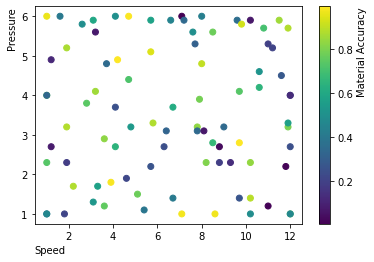

Printed material accuracy of 0.7289098500201607
Iteration #82
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 83
Speed (mm/s):  11.1
Pressure (bars):  1.1 

Needle (mm):  2.4 



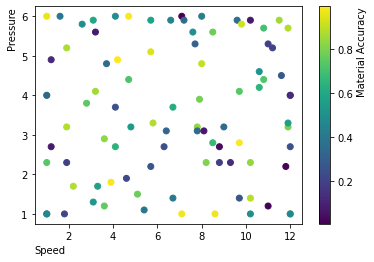

Printed material accuracy of 0.7455080547575987
Iteration #83
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 84
Speed (mm/s):  11.6
Pressure (bars):  5.0 

Needle (mm):  1.6 



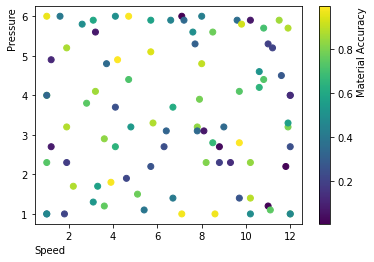

Printed material accuracy of 0.5826130769746644
Iteration #84
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 85
Speed (mm/s):  4.8
Pressure (bars):  1.3 

Needle (mm):  1.3 



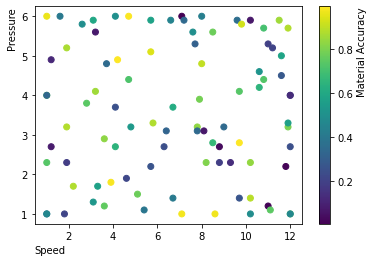

Printed material accuracy of 0.3920031287088821
Iteration #85
Ask Trieste for configuration
Trieste took 0.15s to answer
New Configuration to Try # 86
Speed (mm/s):  6.2
Pressure (bars):  1.8 

Needle (mm):  2.6 



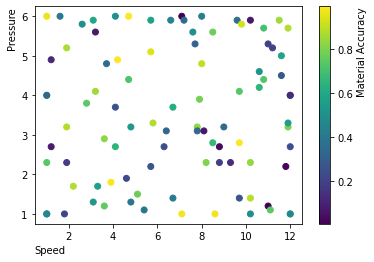

Printed material accuracy of 0.10844857348984871
Iteration #86
Ask Trieste for configuration
Trieste took 0.15s to answer
New Configuration to Try # 87
Speed (mm/s):  7.2
Pressure (bars):  2.6 

Needle (mm):  2.2 



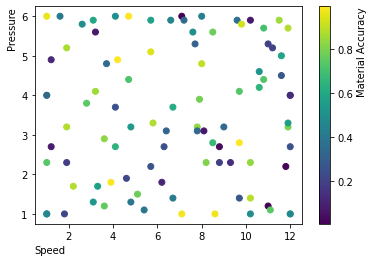

Printed material accuracy of 0.8568560669792582
Iteration #87
Ask Trieste for configuration
Trieste took 0.15s to answer
New Configuration to Try # 88
Speed (mm/s):  1.3
Pressure (bars):  2.7 

Needle (mm):  4.0 



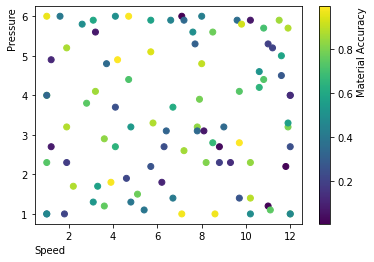

Printed material accuracy of 0.057497409206143435
Iteration #88
Ask Trieste for configuration
Trieste took 0.15s to answer
New Configuration to Try # 89
Speed (mm/s):  8.1
Pressure (bars):  4.5 

Needle (mm):  1.1 



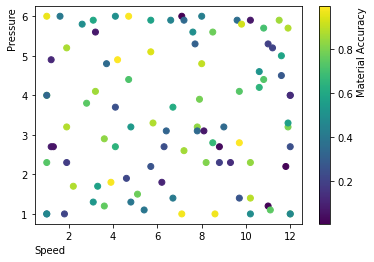

Printed material accuracy of 0.620815993206118
Iteration #89
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 90
Speed (mm/s):  1.1
Pressure (bars):  5.3 

Needle (mm):  1.2 



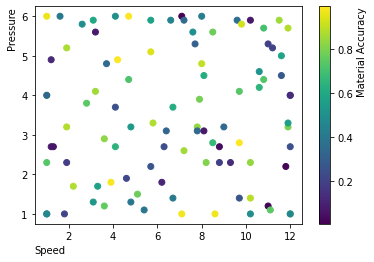

Printed material accuracy of 0.390198950064067
Iteration #90
Ask Trieste for configuration
Trieste took 0.15s to answer
New Configuration to Try # 91
Speed (mm/s):  6.1
Pressure (bars):  2.1 

Needle (mm):  4.0 



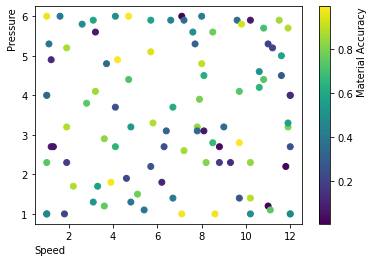

Printed material accuracy of 0.3316798695670625
Iteration #91
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 92
Speed (mm/s):  9.6
Pressure (bars):  4.6 

Needle (mm):  2.4 



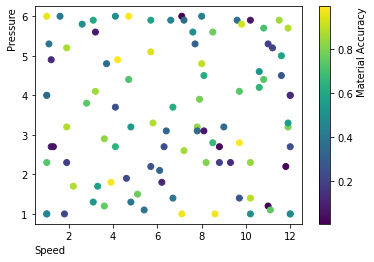

Printed material accuracy of 0.5123874730718915
Iteration #92
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 93
Speed (mm/s):  5.6
Pressure (bars):  1.7 

Needle (mm):  2.3 



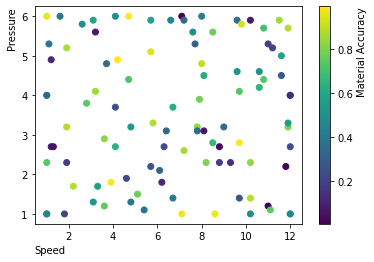

Printed material accuracy of 0.7614103358846959
Iteration #93
Ask Trieste for configuration
Trieste took 0.15s to answer
New Configuration to Try # 94
Speed (mm/s):  1.2
Pressure (bars):  6.0 

Needle (mm):  2.1 



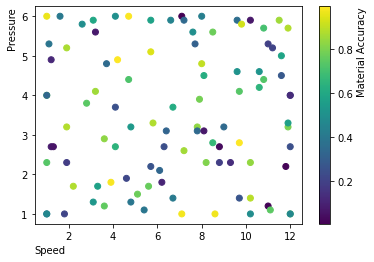

Printed material accuracy of 0.03241359585386816
Iteration #94
Ask Trieste for configuration
Trieste took 0.15s to answer
New Configuration to Try # 95
Speed (mm/s):  6.9
Pressure (bars):  4.6 

Needle (mm):  1.3 



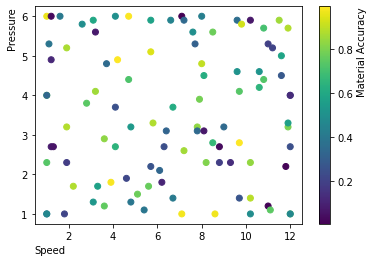

Printed material accuracy of 0.25992059354248565
Iteration #95
Ask Trieste for configuration
Trieste took 0.13s to answer
New Configuration to Try # 96
Speed (mm/s):  10.0
Pressure (bars):  5.5 

Needle (mm):  3.7 



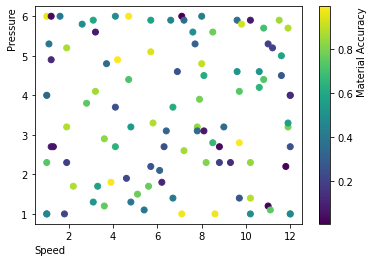

Printed material accuracy of 0.9451279134362062
Iteration #96
Ask Trieste for configuration
Trieste took 0.14s to answer
New Configuration to Try # 97
Speed (mm/s):  6.5
Pressure (bars):  2.2 

Needle (mm):  2.4 



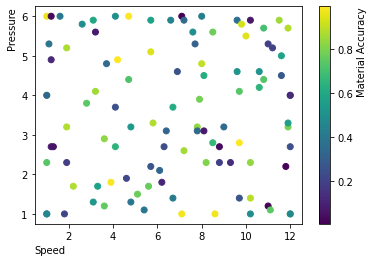

Printed material accuracy of 0.9636882727891813


KeyboardInterrupt: 

In [59]:
%time
max_iterations = 1000
for i in range(max_iterations):
    print("Iteration #{}".format(i))
    print("Ask Trieste for configuration")
    t1 = time()
    new_config = ask_tell.ask()
    t2 = time()
    print("Trieste took {:.2f}s to answer".format(t2-t1))
    for j in range(len(new_config)):
        print('New Configuration to Try #', i + 1)
        speed = np.round(new_config[j][0].numpy(),1)
        pressure =  np.round(new_config[j][1].numpy(),1)
        ng =  np.round(new_config[j][2].numpy(),1)
        print('Speed (mm/s): ', speed)
        print('Pressure (bars): ', pressure, '\n')
        print('Needle (mm): ', ng, '\n')
        
    plot_ask_tell_results(ask_tell.to_result())
    
    # "dummy" printing parameters here (random)
    printed_material_accuracy = random.random()
    print("Printed material accuracy of {}".format(printed_material_accuracy))
    
    new_input = Dataset(
    tf.constant(np.array([[speed, pressure, ng]])),
    tf.constant(np.array([[printed_material_accuracy]]))
               )
    ask_tell.tell({"OBJECTIVE":new_input})

### Main take-away:

Time should not be an issue for this dimensionality of the problem!! 
(left to test out with different GP/acquisition hyper-parameters)

### TODO for this workflow:

1. Set up the iterations on one of the given distributions (from the predefined [single objectives](https://secondmind-labs.github.io/trieste/0.12.0/autoapi/trieste/objectives/single_objectives/index.html)) - so that we can better understand what is going on and follow convergence of an actual function (rather than having an imaginary random output always)


2. Plot the speed-needle, pressure-needle views too.


3. Test out the times with different parameters of the inputs.


4. Any other packages we might want to test out? This one has a really bad documentation (from what I have seen) - although it seems to have really good wrapper functions.  


5. Summarize the timing of the experiment - computation in a spreadsheet (set up day 1 - day X experiments with how much material will need to be printed given the convergence etc.)

### TODO general:

Think about other potential problems we might want to address with the feasibility analysis. 

- Summarize **key points from the other BO paper** - this can be a proof of concept besides out initial experiments (it shows that someone else has done it successfully). What were the good sides and what were the potential problems they experienced with BO?


- Think about the material accuracy as the **objective function**: is this the best metric to estimate the quality of the print for your S2.2 and S2.3? are we sure we can rely on it? do we want to think about a multi-objective (a combination of a couple of factors)?


- What to suggest for **other materials from SA2.2/SA2.3**? Should we just say if this works well for SA2.1 it can be applied to other materials during printing too? If not, can always revert to full factorial.


- How to deal with the fact that our outputs are not deterministic? Material accuracy will vary across the experiments. Is there some variation of the BO that can take this into account?


- How to define the target pring quality or maximum number of iteration? How much bio-ink will we have?
